### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 10]

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [4]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

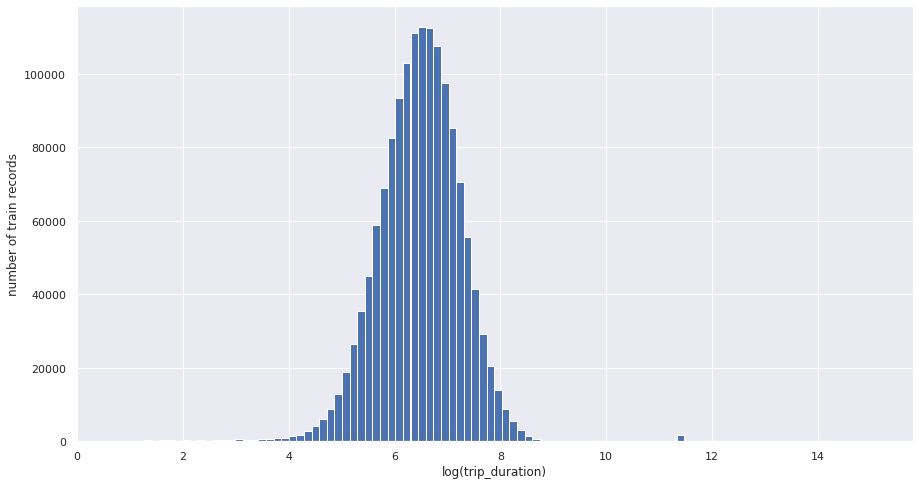

In [5]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

fig, axs = plt.subplots(figsize=(15, 8))
axs.hist(train['log_trip_duration'].values, bins=100)
axs.set_xlabel('log(trip_duration)')
axs.set_ylabel('number of train records');

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [6]:
train = train.drop(['trip_duration'], axis=1)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [7]:
start_mse=(train.log_trip_duration.std())**2
start_mse

0.6332331966652264

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [8]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
train['weekday'] = train.pickup_datetime.dt.dayofweek
train['number_of_week'] = train.pickup_datetime.dt.isocalendar().week
train['month'] = train.pickup_datetime.dt.month
train['hour'] = train.pickup_datetime.dt.hour
train['day_of_year'] = train.pickup_datetime.dt.day_of_year

In [9]:
df_count_plot = train.groupby('day_of_year')['vendor_id'].count().reset_index()

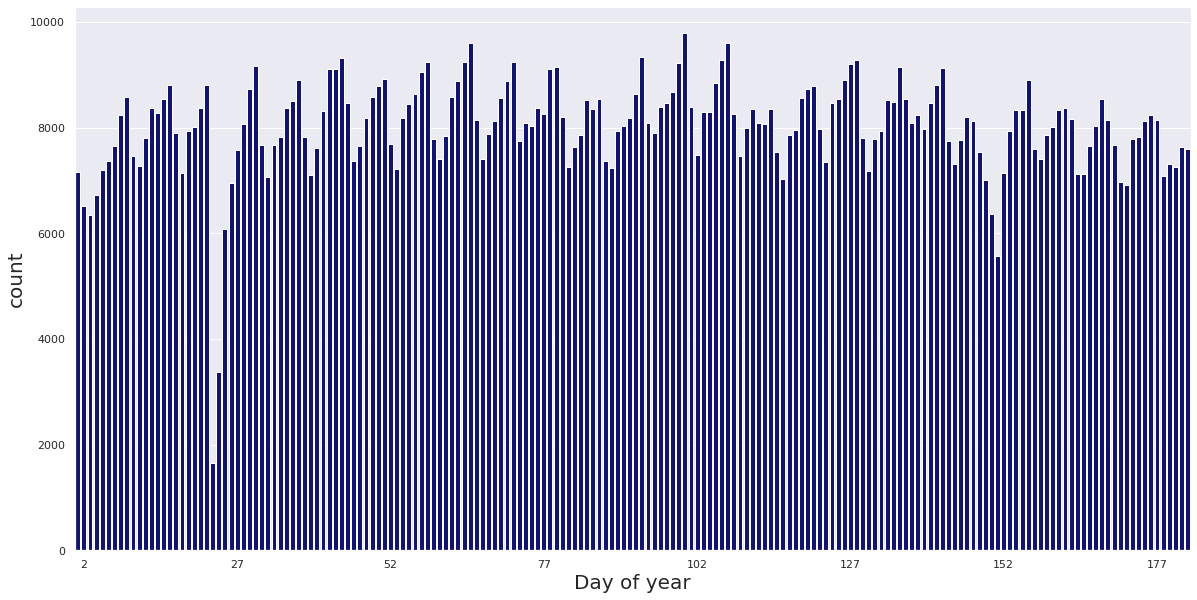

In [10]:
f, ax = plt.subplots(figsize=(20, 10))

ax = sns.countplot(x='day_of_year',color='darkblue', data=train)
axes = plt. gca()
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
ax.set_xlabel('Day of year')
plt.xticks(np.arange(min(train['day_of_year']), max(train['day_of_year'])+1, 25));

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

Text(0, 0.5, 'Number of travels')

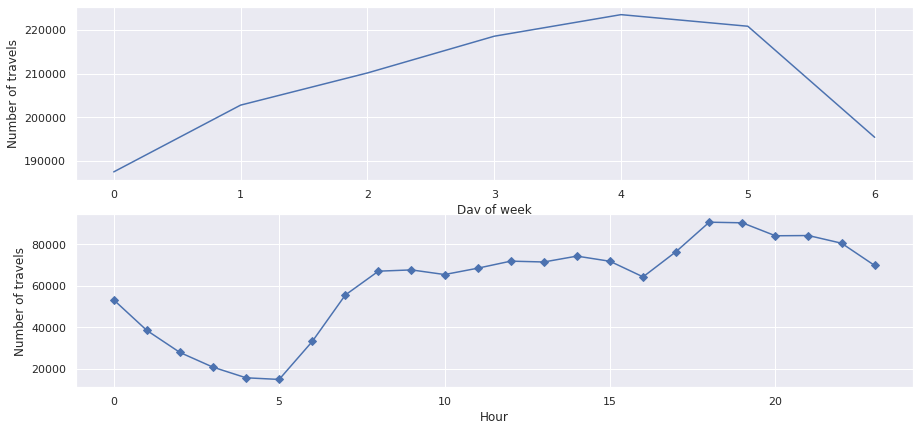

In [11]:
f, ax = plt.subplots(figsize=(15, 7), nrows=2)
ax[0].plot(train.groupby('weekday')['id'].count())
ax[0].set_xlabel('Day of week')
ax[0].set_ylabel('Number of travels')

ax[1].plot(train.groupby(train['pickup_datetime'].dt.hour)['id'].count(), marker='D')
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Number of travels')


**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

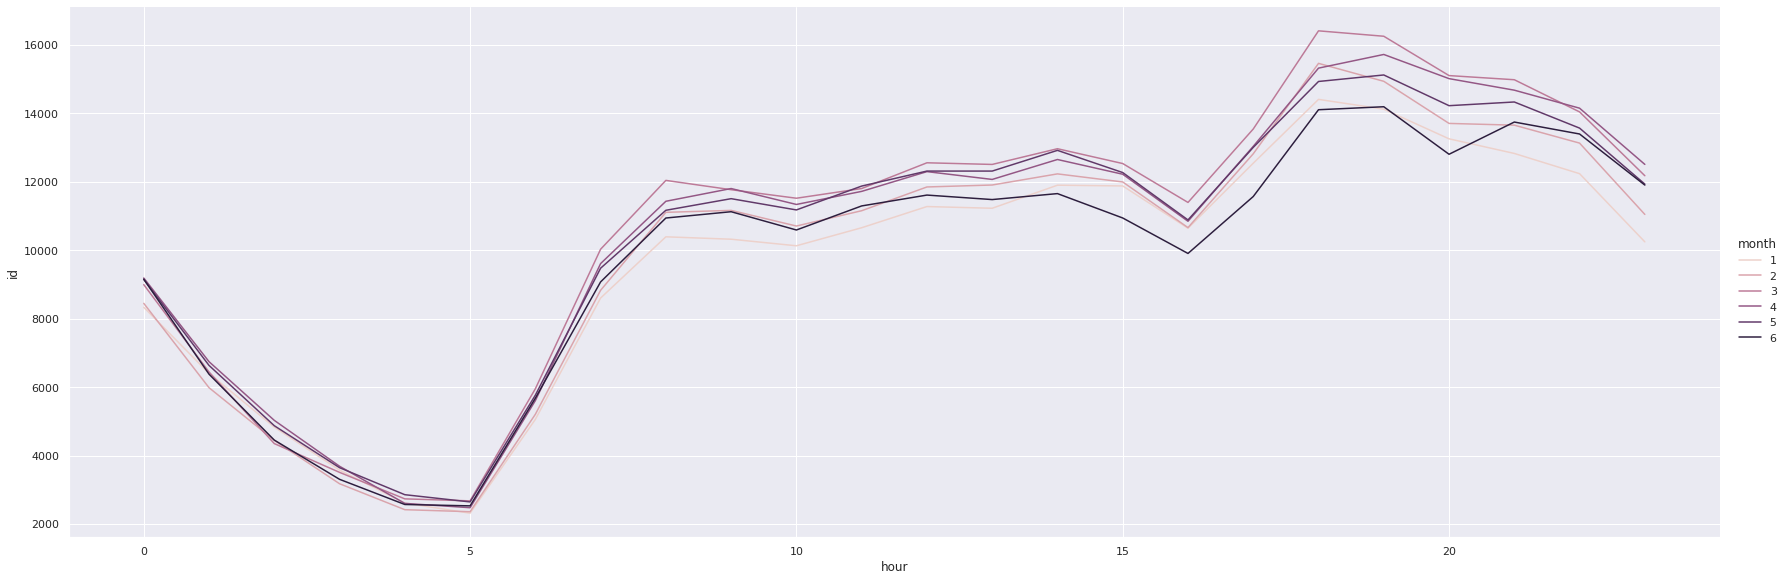

In [12]:
ax = sns.relplot(data=train.groupby(['month', 'hour'])['id'].nunique().reset_index(),
            x='hour',
            y='id',
            hue='month',
            height=8,
            aspect=3,
            kind='line')

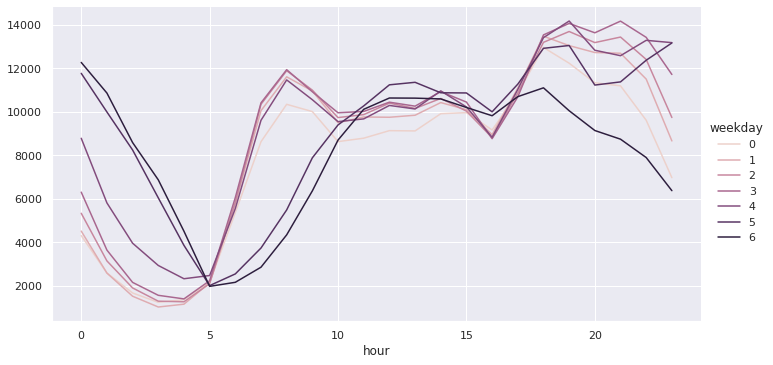

In [13]:
ax=sns.relplot(data=train.groupby('weekday')['hour'].value_counts(),
               x="hour",
               y=train.groupby('weekday')['hour'].value_counts().values,
               hue="weekday",
               height=5,
               aspect=2,
               kind="line")

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [15]:
train['anom1'] = train['day_of_year'].apply(lambda x: int(x == 23))
train['anom2'] = train['day_of_year'].apply(lambda x: int(x == 24))

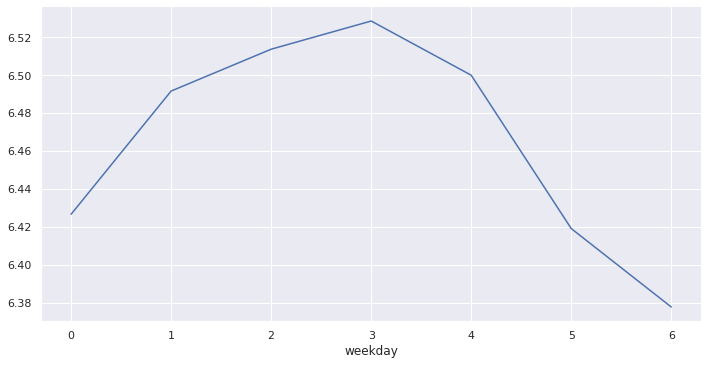

In [16]:
sns.relplot(data=train.groupby('weekday')['log_trip_duration'].mean(),
            x='weekday',
            y = train.groupby('weekday')['log_trip_duration'].mean().values,
            kind='line',
            height=5,
            aspect=2);

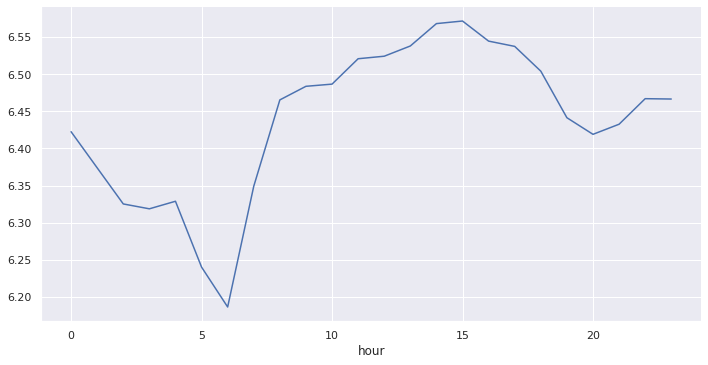

In [17]:
sns.relplot(data=train.groupby('hour')['log_trip_duration'].mean(),
            x='hour',
            y = train.groupby('hour')['log_trip_duration'].mean().values,
            kind='line',
            height=5,
            aspect=2);

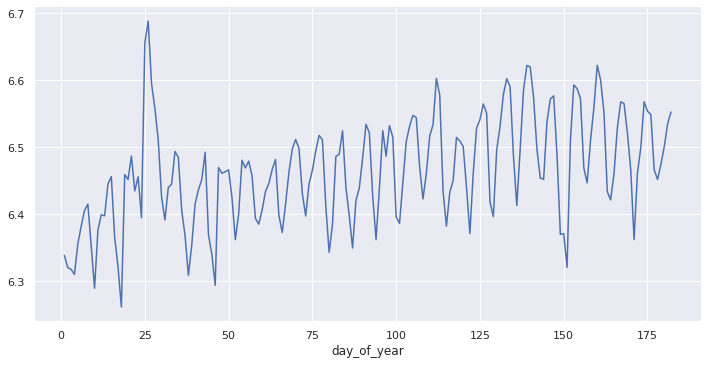

In [18]:
sns.relplot(data=train.groupby('day_of_year')['log_trip_duration'].mean(),
            x='day_of_year',
            y = train.groupby('day_of_year')['log_trip_duration'].mean().values,
            kind='line',
            height=5,
            aspect=2);

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error as mse

In [20]:
X_train, X_test = train_test_split(train, test_size=0.3, random_state=42)

In [21]:
categorical = ['month', 'weekday', 'anom1', 'anom2', 'hour']
numeric = ['day_of_year']
features = categorical + numeric

column_transformer = ColumnTransformer([
    ('one hot encoding', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('skalling', StandardScaler(), numeric)
])

pipe = Pipeline([
    ('transformation', column_transformer),
    ('regression', Ridge())
])

model = pipe.fit(X_train[features], X_train['log_trip_duration'])
y_pred = model.predict(X_test[features])

print("Test MSE = %.4f" % mse(X_test['log_trip_duration'], y_pred))

Test MSE = 0.6213


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [22]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [23]:
# show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitu 

In [24]:
# show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

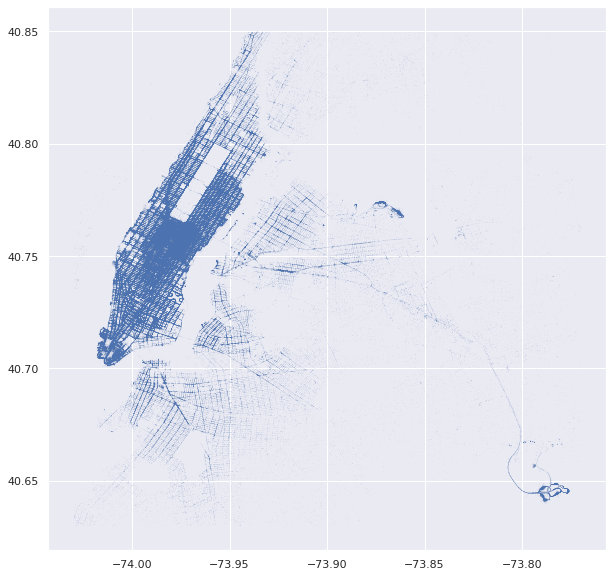

In [25]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
train = train[(train.pickup_longitude> xlim[0]) & (train.pickup_longitude < xlim[1])]
train = train[(train.dropoff_longitude> xlim[0]) & (train.dropoff_longitude < xlim[1])]
train = train[(train.pickup_latitude> ylim[0]) & (train.pickup_latitude < ylim[1])]
train = train[(train.dropoff_latitude> ylim[0]) & (train.dropoff_latitude < ylim[1])]

longitude = list(train.pickup_longitude) + list(train.dropoff_longitude)
latitude = list(train.pickup_latitude) + list(train.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show();

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [26]:
from haversine import haversine

In [27]:
train['distance'] = train.apply(lambda x: haversine((x['pickup_longitude'], x['pickup_latitude']),
                                  (x['dropoff_longitude'], x['dropoff_latitude'])), axis=1).values

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [28]:
train['log_distance']= train.apply(lambda x: np.log1p(x.distance), axis=1)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [29]:
train[['log_trip_duration', 'log_distance', 'distance']].corr().iloc[1:, 0].to_frame()

,log_trip_duration
log_distance,0.670513
distance,0.548039


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [30]:
train['speed'] = train['distance'] / np.exp(train['log_trip_duration'])

<AxesSubplot:>

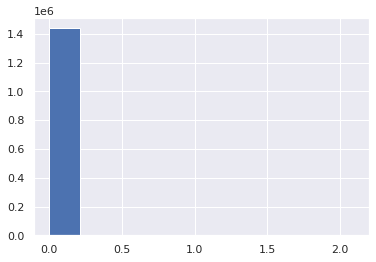

In [31]:
train['speed'].hist()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

Text(0, 0.5, 'Количество')

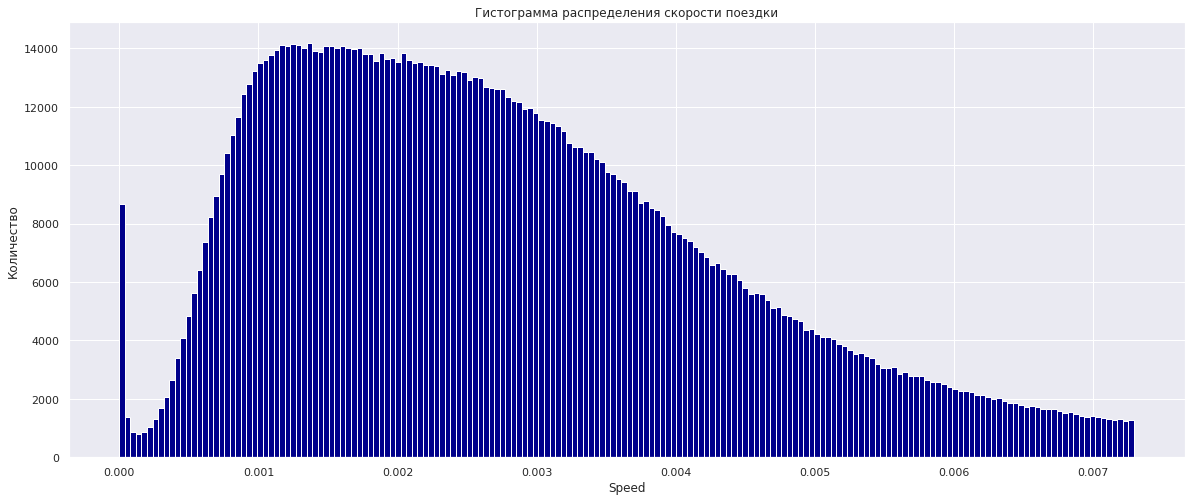

In [32]:
threshold = train['speed'].quantile(0.95)

f, ax = plt.subplots(figsize=(20, 8))
ax.hist(train[train['speed'] < threshold]['speed'], color='darkblue', bins='auto')
ax.set_title('Гистограмма распределения скорости поездки')
ax.set_xlabel('Speed')
ax.set_ylabel('Количество')

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

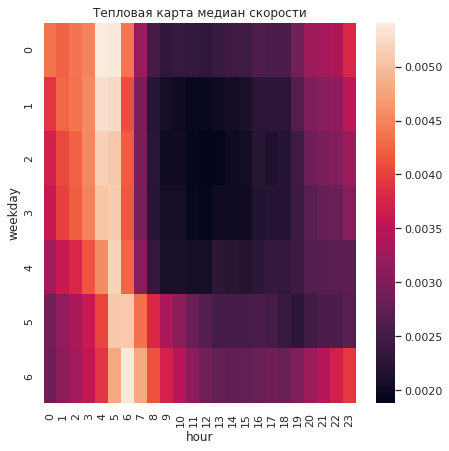

In [33]:
data_for_hm = train.groupby(['weekday', 'hour'])['speed'].median().unstack()

f, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(data_for_hm)
ax.set_title('Тепловая карта медиан скорости');

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [34]:
train = train.drop(['speed'], axis=1)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [35]:
hour = train['hour']
train['free_road'] = ((hour > 3) & (hour < 7)).map(int)
train['traffic_jam'] = ((hour > 9) & (hour < 15)).map(int)

In [36]:
train.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_week,month,hour,day_of_year,anom1,anom2,distance,log_distance,free_road,traffic_jam
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,11,3,17,74,0,0,1.94998,1.081798,0,0


**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [37]:
%%time
train['Kennedi_pickup'] = train.apply(lambda x: int(((40.633191)<=(x['pickup_latitude'])<=(40.660043))&((-73.793316)<= (x['pickup_longitude']) <=(-73.780070))), axis=1)
train['Kennedi_dropoff'] = train.apply(lambda x: int(((40.633191)<=(x['dropoff_latitude'])<=(40.660043))&((-73.793316)<= (x['dropoff_longitude']) <=(-73.780070))), axis=1)

train['Laguardia_pickup'] = train.apply(lambda x: int(((40.766937)<=(x['pickup_latitude'])<=(40.779799))&((-73.877414)<= (x['pickup_longitude']) <=(-73.8628986))), axis=1)
train['Laguardia_dropoff'] = train.apply(lambda x: int(((40.766937)<=(x['dropoff_latitude'])<=(40.779799))&((-73.897414)<= (x['dropoff_longitude']) <=(-73.8622986))), axis=1)

CPU times: user 3min 22s, sys: 3.06 s, total: 3min 25s
Wall time: 3min 25s


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

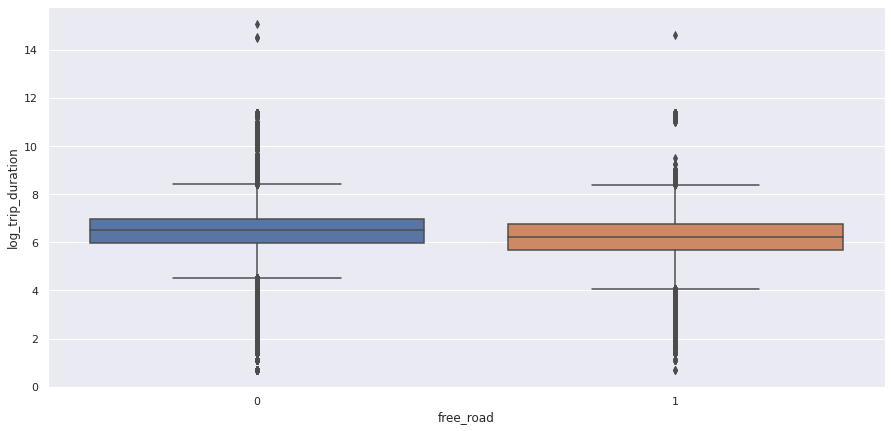

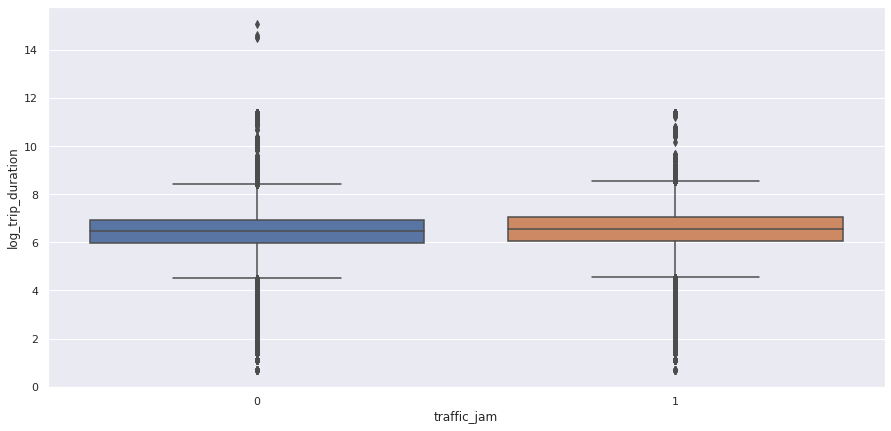

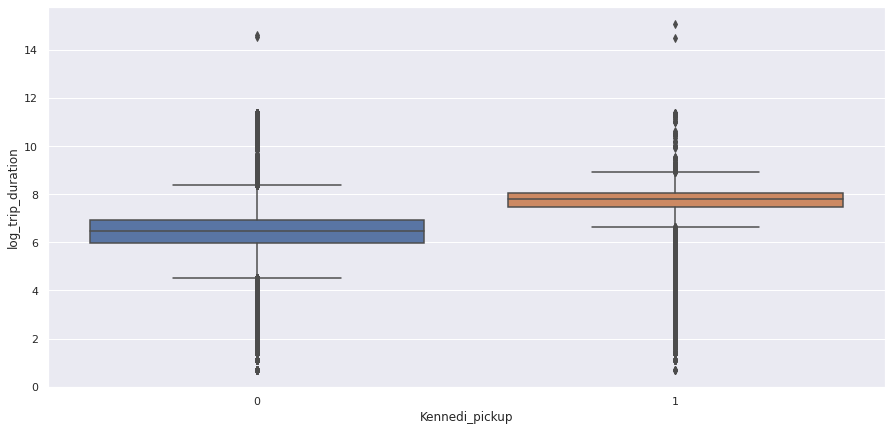

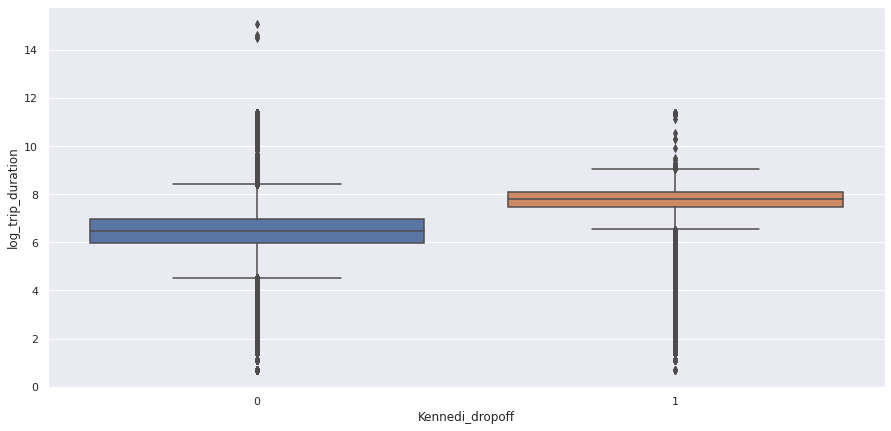

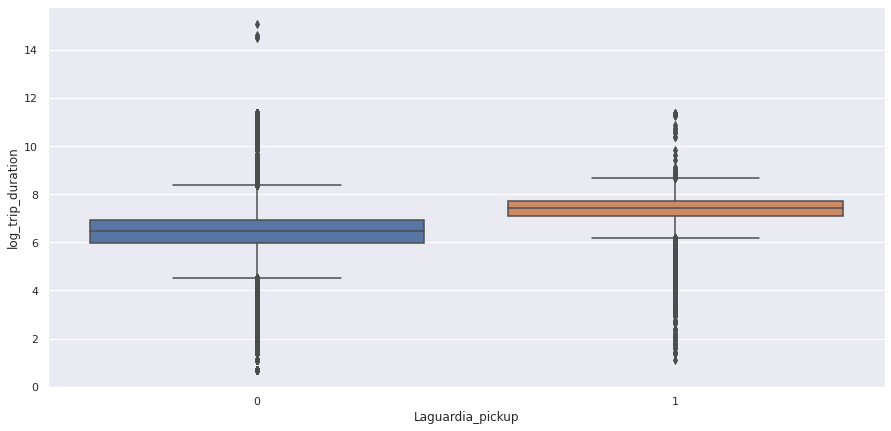

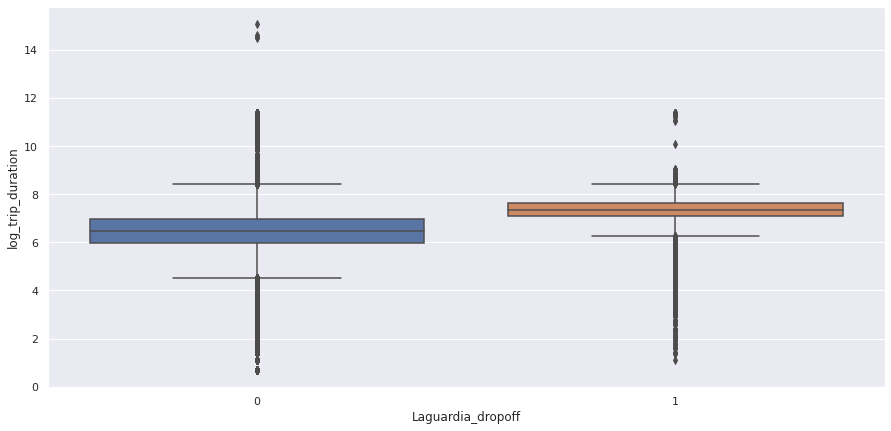

In [38]:
for x in ['free_road', 'traffic_jam', 'Kennedi_pickup', 'Kennedi_dropoff', 'Laguardia_pickup', 'Laguardia_dropoff']:
    f, ax = plt.subplots(figsize=(15, 7))
    ax = sns.boxplot(x=x, y='log_trip_duration', data=train)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, x1,y1,x2,y2,xc,yc):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.xc = xc
        self.yc = yc


    def fit_transform(self, df):
        x_grid = np.linspace(self.x1, self.x2, self.xc)
        y_grid = np.linspace(self.y1, self.y2, self.yc)
        last_x = len(x_grid)
        last_y = len(y_grid)
        
        X = df.copy()

        X['x_cell'] = X['pickup_longitude'].apply(lambda x: np.searchsorted(x_grid, x))
        X['y_cell'] = X['pickup_latitude'].apply(lambda x: np.searchsorted(y_grid, x))
        X['pickup_position'] = X.apply(lambda row: -1 if (row['x_cell']== 0 or row['y_cell']==0 or row['y_cell']==last_y or row['x_cell']==last_x) \
                                            else (row['y_cell'] * (self.xc-1) + row['x_cell']), axis=1)
        
        X['x_cell'] = X['dropoff_longitude'].apply(lambda x: np.searchsorted(x_grid, x))
        X['y_cell'] = X['dropoff_latitude'].apply(lambda x: np.searchsorted(y_grid, x))
        X['dropoff_position'] = X.apply(lambda row: -1 if (row['x_cell']== 0 or row['y_cell']==0 or row['y_cell']==last_y or row['x_cell']==last_x) \
                                            else (row['y_cell'] * (self.xc-1) + row['x_cell']), axis=1)       
        
        return X.drop(['x_cell', 'y_cell'], axis=1)

In [40]:
Mytransformer = MapGridTransformer(-74.014901, 40.701559, -73.930014, 40.801323, 5, 6)
train = Mytransformer.fit_transform(train)
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,distance,log_distance,free_road,traffic_jam,Kennedi_pickup,Kennedi_dropoff,Laguardia_pickup,Laguardia_dropoff,pickup_position,dropoff_position
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.949980,1.081798,0,0,0,0,0,0,18,19
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2.132181,1.141730,0,0,0,0,0,0,10,9
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,3.359043,1.472253,0,1,0,0,0,0,18,5
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0.475520,0.389010,0,0,0,0,0,0,5,5
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0.328461,0.284021,0,1,0,0,0,0,22,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,1.422854,0.884946,0,1,0,0,0,0,14,9
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,3.738329,1.555685,0,0,0,0,0,0,13,23
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,5.378575,1.852945,1,0,0,0,0,0,19,5
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,0.864020,0.622736,0,0,0,0,0,0,14,14


In [41]:
# here have to be values with -1
train['pickup_position'].value_counts().sort_index()

-1     127723
 5      70626
 6      20079
 7       4774
 8       1765
 9     130464
 10    143426
 11       942
 12       641
 13     86728
 14    313052
 15     68073
 16      3680
 17      7279
 18    154180
 19    172445
 20     25201
 21         8
 22     36312
 23     55960
 24     15268
Name: pickup_position, dtype: int64

In [66]:
train[train['pickup_position'].isin([-1, 5, 6, 7, 18])]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,anom2,log_distance,free_road,traffic_jam,Kennedi_pickup,Kennedi_dropoff,Laguardia_pickup,Laguardia_dropoff,pickup_position,dropoff_position
0,id2875421,1,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,1,...,0,1.081798,0,0,0,0,0,0,18,19
2,id3858529,1,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,1,...,0,1.472253,0,1,0,0,0,0,18,5
3,id3504673,1,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,1,...,0,0.389010,0,0,0,0,0,0,5,5
10,id1436371,1,2016-05-10 22:08:41,2016-05-10 22:29:55,1,-73.982651,40.763840,-74.002228,40.732990,1,...,0,1.215956,0,0,0,0,0,0,18,9
18,id3552682,0,2016-06-27 09:55:13,2016-06-27 10:17:10,1,-74.003983,40.713013,-73.979195,40.749924,1,...,0,1.381194,0,0,0,0,0,0,5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458628,id0986544,1,2016-05-30 03:08:19,2016-05-30 03:14:10,2,-73.988632,40.721378,-73.975548,40.728519,1,...,0,0.904756,0,0,0,0,0,0,6,10
1458629,id3109086,1,2016-06-24 10:33:51,2016-06-24 10:43:52,1,-73.959618,40.808941,-73.947922,40.830189,1,...,0,0.898243,0,1,0,0,0,0,-1,-1
1458632,id0469946,1,2016-03-06 11:04:48,2016-03-06 11:17:45,2,-74.015572,40.710892,-73.996620,40.743633,1,...,0,1.204138,0,1,0,0,0,0,-1,13
1458635,id3027038,1,2016-05-19 14:46:55,2016-05-19 14:50:52,1,-73.985390,40.763020,-73.989708,40.767502,1,...,0,0.405106,0,1,0,0,0,0,18,18


/home/vyacheslav/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


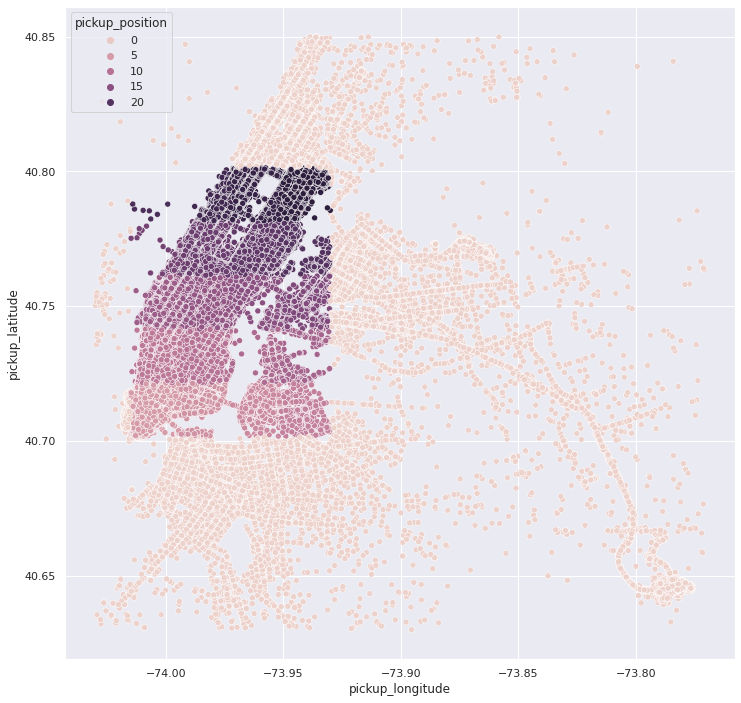

In [71]:
df = train[train['pickup_position']==-1]

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x='pickup_longitude', y='pickup_latitude',
                     data=train,
                     hue='pickup_position')

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [43]:
train = train.drop('distance', axis=1)

In [44]:
categorical = ['month', 'weekday', 'anom1', 'anom2', 'hour', 'dropoff_position', \
               'pickup_position', 'Laguardia_dropoff', 'Laguardia_pickup', 'Kennedi_dropoff', \
              'Kennedi_pickup', 'traffic_jam', 'free_road']
numeric = ['day_of_year', 'log_distance']
features = categorical + numeric

column_transformer = ColumnTransformer([
    ('one hot encoding', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('skalling', StandardScaler(), numeric)
])

pipe = Pipeline([
    ('transformation', column_transformer),
    ('regression', Ridge())
])

X_train, X_test = train_test_split(train, test_size=0.3, random_state=42)

Y_test = X_test['log_trip_duration']
X_test = X_test.drop('log_trip_duration', axis=1)

model = pipe.fit(X_train[features], X_train['log_trip_duration'])

y_pred = model.predict(X_test[features])

print("Test MSE = %.8f" % mse(Y_test, y_pred))

Test MSE = 0.29862794


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [45]:
train[['vendor_id', 'passenger_count', 'store_and_fwd_flag']].nunique()

vendor_id             2
passenger_count       7
store_and_fwd_flag    2
dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

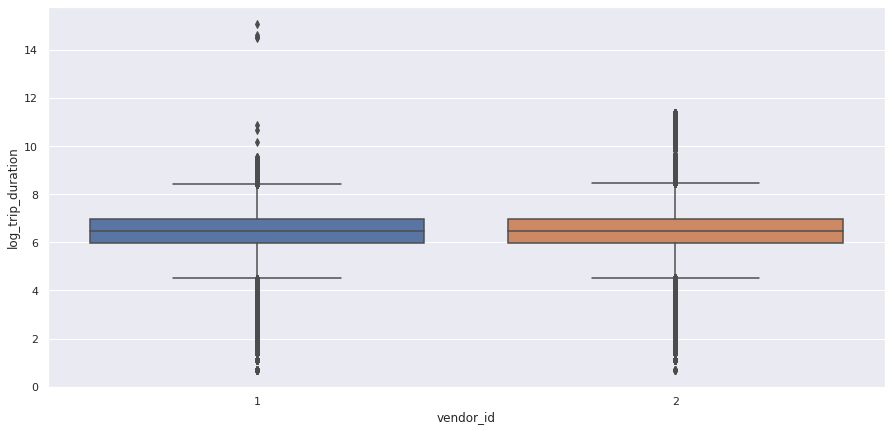

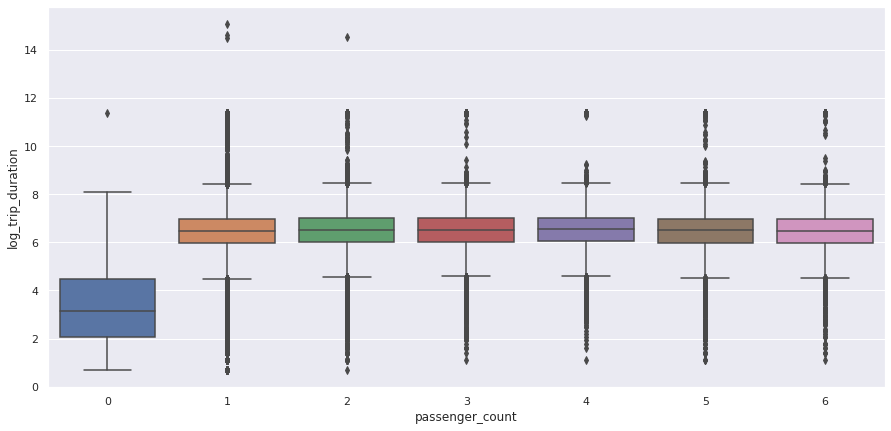

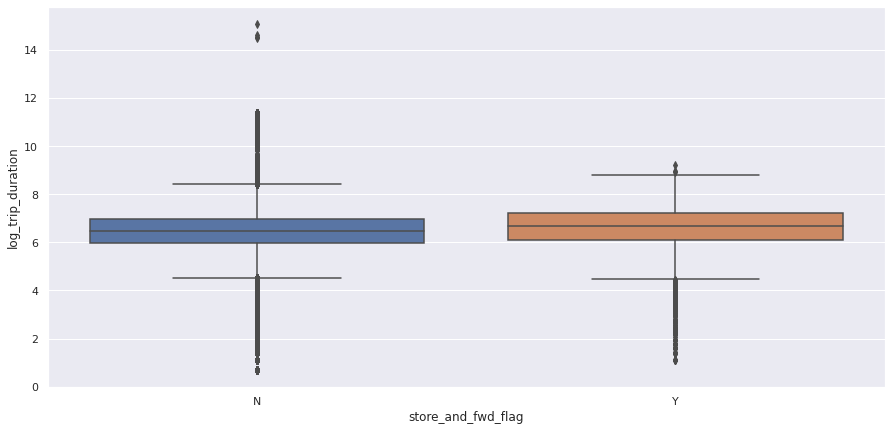

In [46]:
for x in ['vendor_id', 'passenger_count', 'store_and_fwd_flag']:
    f, ax = plt.subplots(figsize=(15, 7))
    ax = sns.boxplot(x=x, y='log_trip_duration', data=train)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [47]:
train['vendor_id'] = train['vendor_id'].map({2:1, 1:0})
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N': 1, 'Y': 0})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [54]:
train.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,anom2,log_distance,free_road,traffic_jam,Kennedi_pickup,Kennedi_dropoff,Laguardia_pickup,Laguardia_dropoff,pickup_position,dropoff_position
0,id2875421,1,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,1,...,0,1.081798,0,0,0,0,0,0,18,19


In [55]:
categorical=['month', 'anom2', 'anom1', 'weekday', 'hour', 'traffic_jam', 'free_road',
                  'Kennedi_pickup', 'Kennedi_dropoff', 'Laguardia_pickup', 'Laguardia_dropoff', 
                  'dropoff_position','pickup_position', 'vendor_id','store_and_fwd_flag', 'passenger_count']

numeric_features=['day_of_year', 'log_distance']
features=numeric_features+categorical



column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

X_train, X_test = train_test_split(train, test_size=0.3, random_state=42)

Y_test = X_test['log_trip_duration']
X_test = X_test.drop('log_trip_duration', axis=1)

model = pipeline.fit(X_train[features], X_train['log_trip_duration'])

y_pred = model.predict(X_test[features])

print("Test MSE = %.8f" % mse(Y_test, y_pred))

Test MSE = 0.29820619


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.